<a href="https://colab.research.google.com/github/guscassiano/Dio_ML_bootcamp/blob/image_recommendation_system/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Célula 1: Instalação de Bibliotecas e Importações
# ---------------------------------------------------------
Vamos garantir que temos todas as ferramentas necessárias.
A biblioteca 'gdown' será usada para baixar nosso dataset de exemplo do Google Drive.

In [1]:
!pip install gdown

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import gdown
from tqdm import tqdm
import zipfile

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# Célula 2: Download e Preparação do Dataset
# ---------------------------------------------------------
Instala a biblioteca do Kaggle.
Ele contém diversas categorias como sapatos, camisetas, relógios, etc.


In [5]:
!pip install kaggle

import os
import json
import zipfile
from tqdm import tqdm

In [6]:
# Configurando a API do Kaggle
# Execute esta célula e cole seu usuário e chave do Kaggle quando solicitado.
kaggle_username = input("Digite seu username do Kaggle: ")
kaggle_key = input("Digite sua chave (key) da API do Kaggle: ")

Digite seu username do Kaggle: gustavocassiano
Digite sua chave (key) da API do Kaggle: XXXXXX


In [7]:
api_token = {"username": kaggle_username, "key": kaggle_key}

# Cria o diretório e salva o arquivo kaggle.json
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

# Baixando o dataset "Fashion Product Images (Small)"
# Este é um ótimo dataset com 44,000 imagens de produtos e seus metadados.
print("\nBaixando o dataset de imagens de produtos de moda...")
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

# Descompactando o arquivo
output_zip = 'fashion-product-images-small.zip'
output_dir = 'fashion-dataset/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Listando os arquivos de imagem
image_folder = os.path.join(output_dir, 'images')
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Vamos limitar a um número gerenciável para uma execução mais rápida no Colab
image_paths = image_paths[:5000]

print(f"\nDataset extraído. Total de imagens a serem processadas: {len(image_paths)}")


Baixando o dataset de imagens de produtos de moda...
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 92% 518M/565M [00:06<00:01, 41.8MB/s]
100% 565M/565M [00:06<00:00, 90.3MB/s]

Dataset extraído. Total de imagens a serem processadas: 5000


# Célula 3: Carregando o Modelo Pré-treinado (VGG16)
# ---------------------------------------------------------
Aqui está o coração do nosso sistema.
Usaremos o VGG16 treinado no ImageNet.
'include_top=False' significa que estamos removendo a última camada de classificação.
'pooling='avg'' adiciona uma camada de Average Pooling no final, o que nos dá um vetor de tamanho fixo para cada imagem.


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

print("Modelo VGG16 carregado com sucesso!")
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo VGG16 carregado com sucesso!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Célula 4: Função para Extrair Características (Embeddings)
# ---------------------------------------------------------
Esta função irá pegar o caminho de uma imagem, prepará-la para o modelo
e retornar o vetor de características (embedding).

In [9]:
def extract_features(image_path, model):
    """
    Extrai as características de uma imagem usando o modelo pré-treinado.
    """
    # Carrega a imagem e redimensiona para o tamanho que o VGG16 espera (224x224)
    img = image.load_img(image_path, target_size=(224, 224))

    # Converte a imagem para um array numpy
    img_array = image.img_to_array(img)

    # Adiciona uma dimensão extra para o 'batch'
    expanded_img_array = np.expand_dims(img_array, axis=0)

    # Pré-processa a imagem (normaliza os pixels) da mesma forma que as imagens do ImageNet foram processadas
    preprocessed_img = preprocess_input(expanded_img_array)

    # Usa o modelo para "prever" (extrair as características)
    features = model.predict(preprocessed_img, verbose=0)

    # Retorna o vetor de características achatado (flatten)
    return features.flatten()

# Célula 5: Processando Todas as Imagens e Extraindo Suas Características
# --------------------------------------------------------------------------
Agora, vamos iterar sobre todas as nossas imagens e extrair os embeddings.
Este processo pode levar alguns minutos dependendo do número de imagens e da GPU do Colab.
A barra de progresso (tqdm) nos ajudará a acompanhar.

In [10]:
all_features = []
for path in tqdm(image_paths, desc="Extraindo características das imagens"):
    features = extract_features(path, model)
    all_features.append(features)

# Convertendo a lista de características para um array NumPy
all_features = np.array(all_features)

print(f"\nProcesso concluído. Formato do nosso banco de características: {all_features.shape}")
# O resultado será (número_de_imagens, 512), pois a camada 'avg_pooling' do VGG16 nos dá um vetor de 512 dimensões.

Extraindo características das imagens: 100%|██████████| 5000/5000 [1:02:59<00:00,  1.32it/s]


Processo concluído. Formato do nosso banco de características: (5000, 512)


# Célula 6: Construindo o Índice de Similaridade com Nearest Neighbors
# ---------------------------------------------------------------------
Com todos os vetores em mãos, vamos usar o Scikit-learn para construir um
índice que nos permita encontrar os vizinhos mais próximos de forma eficiente.
A métrica 'cosine' é excelente para medir a similaridade entre vetores de alta dimensão.


In [11]:
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')
neighbors.fit(all_features)

print("Índice de vizinhos mais próximos construído com sucesso!")

Índice de vizinhos mais próximos construído com sucesso!


# Célula 7: Função para Recomendar e Visualizar os Resultados
# -----------------------------------------------------------
Esta é a função final que junta tudo.
Dado o caminho de uma imagem, ela encontra e exibe os produtos mais similares.


In [12]:
def recommend_images(image_path, model, neighbors_model, all_features, image_paths, num_results=6):
    """
    Encontra e exibe imagens similares a uma imagem de entrada.
    """
    # 1. Extrai as características da imagem de busca
    query_features = extract_features(image_path, model)
    query_features = query_features.reshape(1, -1) # Redimensiona para o formato (1, n_features)

    # 2. Encontra os vizinhos mais próximos
    distances, indices = neighbors_model.kneighbors(query_features)

    # 3. Exibe os resultados
    plt.figure(figsize=(15, 8))

    # Imagem de busca
    plt.subplot(2, num_results, int(num_results/2))
    plt.imshow(image.load_img(image_path))
    plt.title("Imagem da Busca")
    plt.axis('off')

    print("-" * 50)
    print(f"Resultados da recomendação para: {os.path.basename(image_path)}")
    print("-" * 50)

    # Imagens recomendadas
    for i, idx in enumerate(indices.flatten()[1:num_results+1]): # Ignora o primeiro resultado (a própria imagem)
        recommended_path = image_paths[idx]
        plt.subplot(2, num_results, num_results + i + 1)
        plt.imshow(image.load_img(recommended_path))
        plt.title(f"Similaridade: {1-distances.flatten()[i+1]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Célula 8: Testando o Sistema de Recomendação
# ------------------------------------------------
Vamos escolher uma imagem aleatória do nosso dataset para testar!

--------------------------------------------------
Resultados da recomendação para: 9497.jpg
--------------------------------------------------


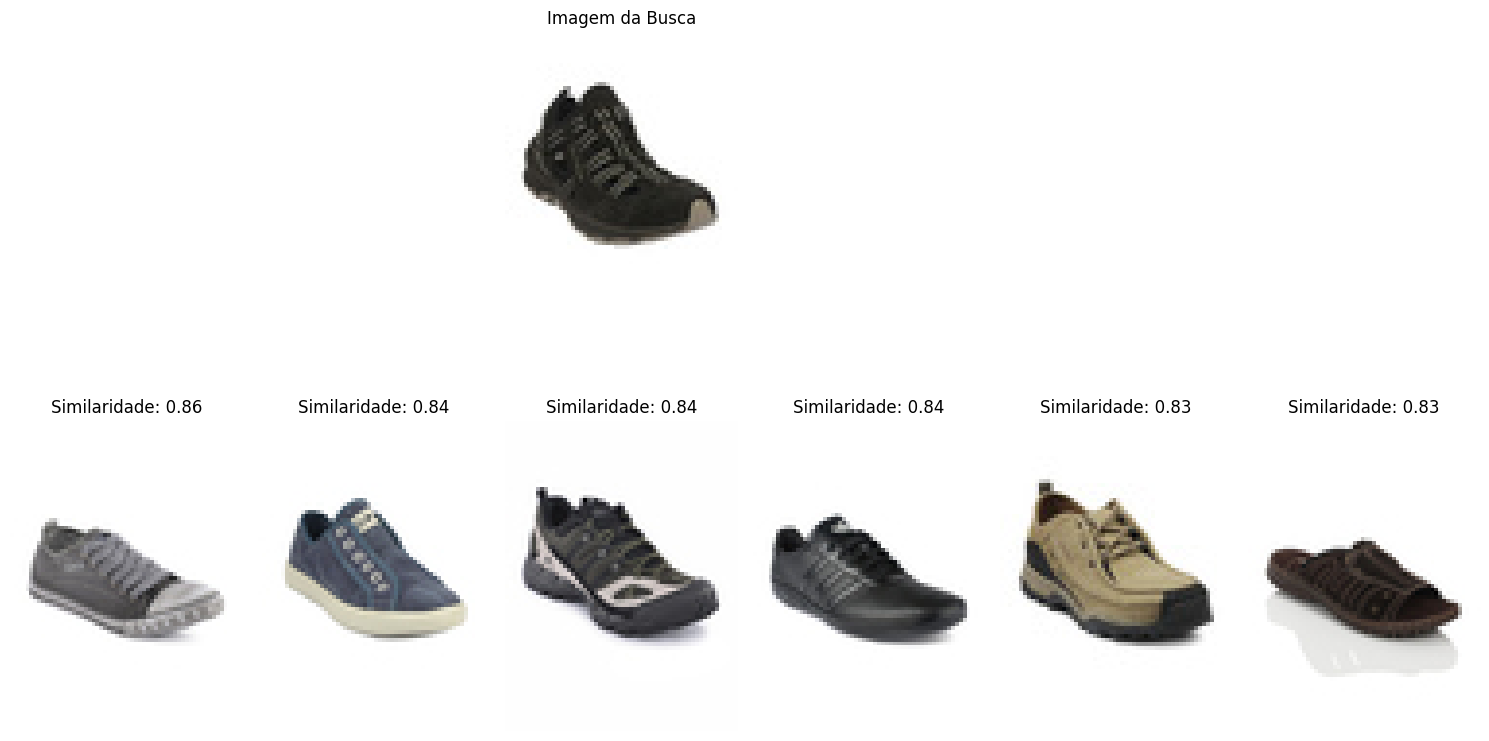

--------------------------------------------------
Resultados da recomendação para: 14165.jpg
--------------------------------------------------


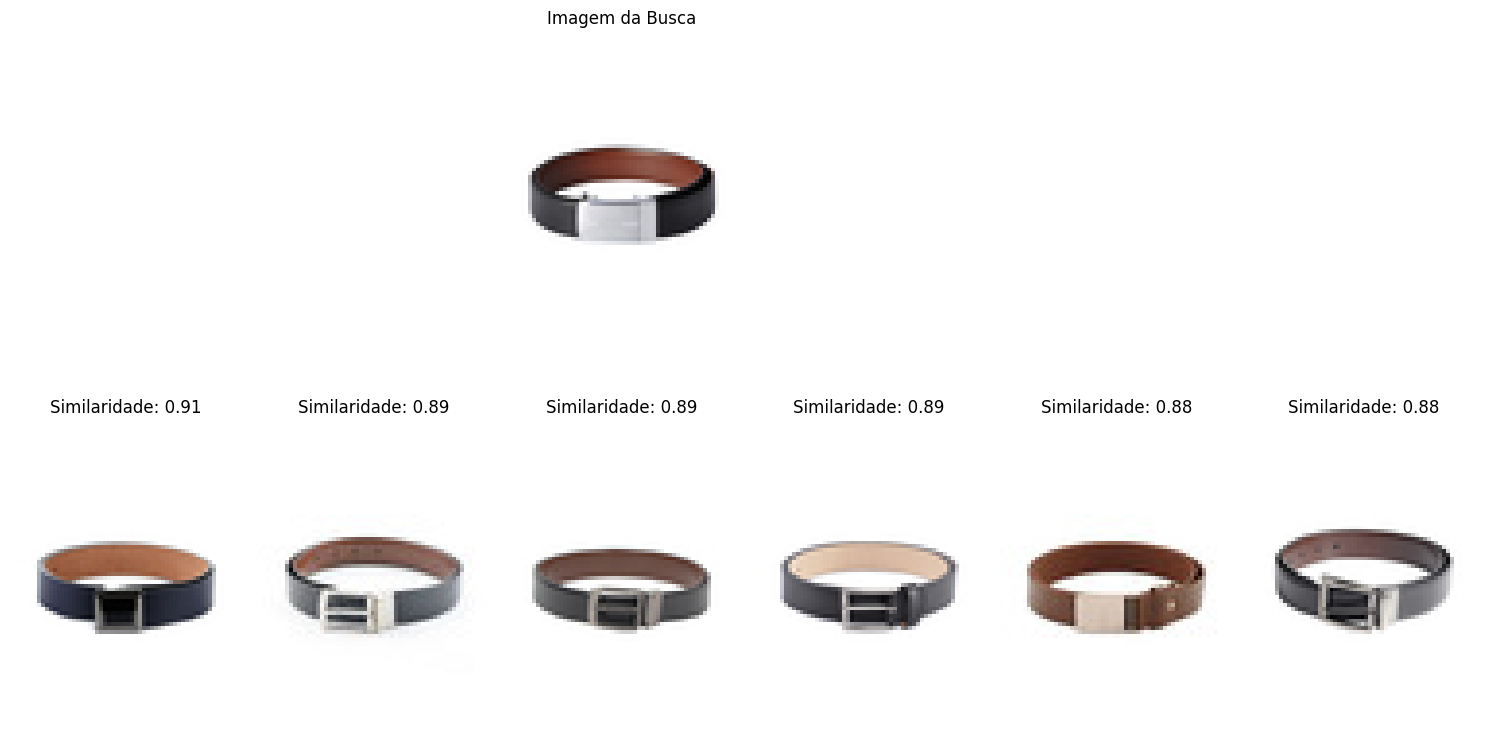

In [13]:
import random

random_index = random.randint(0, len(image_paths) - 1)
test_image_path = image_paths[random_index]

recommend_images(test_image_path, model, neighbors, all_features, image_paths)

# Teste com mais algumas imagens para ver a variedade
random_index = random.randint(0, len(image_paths) - 1)
test_image_path = image_paths[random_index]
recommend_images(test_image_path, model, neighbors, all_features, image_paths)